In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

# Importation des libraries

import sys
import functions
#from functions import *
import gc
import time
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from contextlib import contextmanager
import mlflow
import mlflow.sklearn
import shap
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, auc, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # use this for classification tasks
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
pwd

'/Users/zeyneperdem/Desktop/ds_prep/p7'

In [3]:
# Les versions des libraries
print("Python: ", sys.version)
print("Pandas: ", pd.__version__)
print("Numpy: ", np.__version__)
print("Seaborn: ", sns.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Missingno: ", msno.__version__)
print("Sklearn: ", sklearn.__version__)

Python:  3.9.17 (main, Jul  5 2023, 15:35:09) 
[Clang 14.0.6 ]
Pandas:  1.5.3
Numpy:  1.23.5
Seaborn:  0.12.2
Matplotlib:  3.7.2
Missingno:  0.4.2
Sklearn:  1.2.2


In [4]:
# Les options pour visualisations des dataframes
pd.set_option("display.max_columns", None)

## Importation des données

In [5]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p7/"

In [6]:
dataset = pd.read_csv(path + "dataset.csv")
dataset.head(3)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN          0.0959            0.0529   
2      0.555912      0.729567             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   
2                          NaN              NaN             NaN   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   
2            NaN            NaN            NaN            NaN           NaN   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   
2                   NaN             NaN                      NaN   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   
2                NaN              NaN                NaN   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \

## Exploration Data Analyses pour le fichier "dataset"

In [7]:
functions.info_general(dataset)

************************* * INFORMATIONS GENERALES DE NOTRE DATAFRAME * *************************
----------------------------------------------------------------------------------------------------

Il y a 307507 lignes et 797 colonnes dans notre dataframe.
----------------------------------------------------------------------------------------------------
* On obtiens l'info sur notre dataframe * 
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int64(175)
memory usage: 1.8 GB
None
----------------------------------------------------------------------------------------------------
* On obtient les informations statistiques sur notre dataframe * 
----------------------------------------------------------------------------------------------------


count           mean            std  \
SK_ID_CURR                        307507.0  278181.527256  102790.132982   
TARGET                            307507.0       0.080730       0.272420   
CODE_GENDER                       307507.0       0.658352       0.474263   
FLAG_OWN_CAR                      307507.0       0.340106       0.473745   
FLAG_OWN_REALTY                   307507.0       0.306331       0.460970   
...                                    ...            ...            ...   
CC_NAME_CONTRACT_STATUS_nan_MAX    86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_MEAN   86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_SUM    86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_VAR    86273.0       0.000000       0.000000   
CC_COUNT                           86905.0      37.143605      33.698512   

                                       min       25%       50%       75%  \
SK_ID_CURR                        100002.0  189146.5  278203.0  367143.5   
TARGET                                 0.0       0.0       0.0       0.0   
CODE_GENDER                            0.0       0.0       1.0       1.0   
FLAG_OWN_CAR                           0.0       0.0       0.0       1.0   
FLAG_OWN_REALTY                        0.0       0.0       0.0       1.0   
...                                    ...       ...       ...       ...   
CC_NAME_CONTRACT_STATUS_nan_MAX        0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_MEAN       0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_SUM        0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_VAR        0.0       0.0       0.0       0.0   
CC_COUNT                               1.0      10.0      22.0      75.0   

                                       max  
SK_ID_CURR                        456255.0  
TARGET                                 1.0  
CODE_GENDER                            1.0  
FLAG_OWN_CAR                           1.0  
FLAG_OWN_REALTY                        1.0  
...                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MAX        0.0  
CC_NAME_CONTRACT_STATUS_nan_MEAN       0.0  
CC_NAME_CONTRACT_STATUS_nan_SUM        0.0  
CC_NAME_CONTRACT_STATUS_nan_VAR        0.0  
CC_COUNT                             192.0  

[797 rows x 8 columns]

----------------------------------------------------------------------------------------------------
*On vérifie s'il y a des doublons dans notre dataframe* 
** Il n'y a pas de doublons **
----------------------------------------------------------------------------------------------------
** On vérifie s'il y a des valeurs nulles et on display pourcentage des valeurs nulles par colonne en descendant **
----------------------------------------------------------------------------------------------------
** On a  25.93 % de valeur nulle dans notre dataframe **


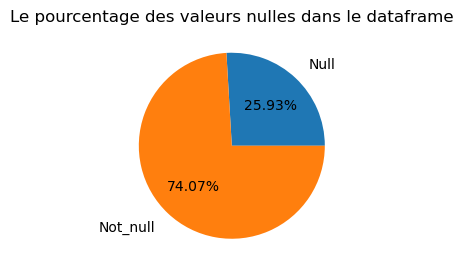

In [8]:
functions.graph_null(dataset)

In [9]:
df_null_dataset = functions.per_null_dataframe(dataset)
# Les colonnes incluent plus de 30% de valeurs manquantes
len(df_null_dataset[df_null_dataset["pourcentage_null"] >30])

253

In [10]:
# On va supprimer ces colonnes 
def remove_columns_with_high_nulls(df, threshold=30):
    """
    Remove columns from DataFrame that have more than a specified percentage of null values.
    
    :param df: DataFrame
    :param threshold: Percentage threshold for null values (default is 30)
    :return: DataFrame with specified columns removed
    """
    per_null = (df.isnull().mean() * 100).round(2)
    columns_to_remove = per_null[per_null > threshold].index
    df_cleaned = df.drop(columns=columns_to_remove)
    return df_cleaned

In [11]:
dataset_removed = remove_columns_with_high_nulls(dataset, threshold=30)
#dataset_removed = dataset_removed.drop("CODE_GENDER", axis=1)
dataset_removed.shape

(307507, 544)

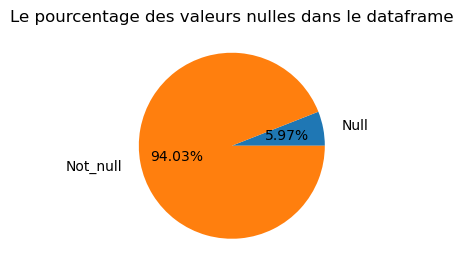

In [12]:
functions.graph_null(dataset_removed)

## On va imputer les valeurs manquantes avec médian de chaque "TARGET" group pour chaque colonne 

In [13]:
# On va remplacer les valeurs infinies par NaN avant de procéder à une imputation
dataset_removed.replace([np.inf, -np.inf], np.nan, inplace=True)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
data_fillna_median = imputer.fit_transform(dataset_removed)
data_fillna_median = pd.DataFrame(data_fillna_median, columns=dataset_removed.columns)
#data_fillna_median = dataset.groupby("TARGET").transform(lambda x: x.fillna(x.median()))
#data_fillna_median["TARGET"] = dataset["TARGET"]

In [14]:
data_fillna_median.isnull().sum().sum()

0

In [15]:
data_fillna_median.shape

(307507, 544)

In [16]:
data_fillna_median.describe()

SK_ID_CURR        TARGET    CODE_GENDER   FLAG_OWN_CAR  \
count  307507.000000  307507.00000  307507.000000  307507.000000   
mean   278181.527256       0.08073       0.658352       0.340106   
std    102790.132982       0.27242       0.474263       0.473745   
min    100002.000000       0.00000       0.000000       0.000000   
25%    189146.500000       0.00000       0.000000       0.000000   
50%    278203.000000       0.00000       1.000000       0.000000   
75%    367143.500000       0.00000       1.000000       1.000000   
max    456255.000000       1.00000       1.000000       1.000000   

       FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count    307507.000000  307507.000000      3.075070e+05  3.075070e+05   
mean          0.306331       0.417047      1.687977e+05  5.990286e+05   
std           0.460970       0.722119      2.371246e+05  4.024926e+05   
min           0.000000       0.000000      2.565000e+04  4.500000e+04   
25%           0.000000       0.000000      1.125000e+05  2.700000e+05   
50%           0.000000       0.000000      1.471500e+05  5.135310e+05   
75%           1.000000       1.000000      2.025000e+05  8.086500e+05   
max           1.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  307507.000000     3.075070e+05               307507.000000   
mean    27108.580714     5.383178e+05                    0.020868   
std     14493.522125     3.692898e+05                    0.013831   
min      1615.500000     4.050000e+04                    0.000290   
25%     16524.000000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34596.000000     6.795000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  307507.000000  307507.000000      307507.000000    307507.000000   
mean   -16037.027271   -2251.582211       -4986.131376     -2994.201670   
std      4363.982424    2136.160141        3522.883030      1509.454566   
min    -25229.000000  -17912.000000      -24672.000000     -7197.000000   
25%    -19682.000000   -2760.000000       -7479.500000     -4299.000000   
50%    -15750.000000   -1648.000000       -4504.000000     -3254.000000   
75%    -12413.000000    -933.000000       -2010.000000     -1720.000000   
max     -7489.000000       0.000000           0.000000         0.000000   

          FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count  307507.000000   307507.000000    307507.000000     307507.000000   
mean        0.999997        0.819887         0.199358          0.998133   
std         0.001803        0.384282         0.399518          0.043164   
min         0.000000        0.000000         0.000000          0.000000   
25%         1.000000        1.000000         0.000000          1.000000   
50%         1.000000        1.000000         0.000000          1.000000   
75%         1.000000        1.000000         0.000000          1.000000   
max         1.000000        1.000000         1.000000          1.000000   

          FLAG_PHONE     FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307507.000000  307507.000000    307507.000000         307507.000000   
mean        0.281057       0.056721         2.152657              2.052461   
std         0.449516       0.231308         0.910677              0.509034   
min         0.000000       0.000000         1.000000              1.000000   
25%         0.000000       0.000000         2.000000              2.000000   
50%         0.000000       0.000000         2.000000              2.000000   
75%         1.000000       0.000000         3.000000              2.000000   
max         1.000000       1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \

In [17]:
def kdeplot_and_boxplot_by_target(df, target_col, feature_cols, figsize=(12, 5)):
    num_feature_cols = len(feature_cols)
    fig, axes = plt.subplots(
        num_feature_cols, 2, figsize=(figsize[0], figsize[1] * num_feature_cols)
    )

    for i, col in enumerate(feature_cols):
        if num_feature_cols == 1:  # Adjust subplots if only one feature column is provided
            ax_kdeplot = axes[0]
            ax_boxplot = axes[1]
        else:
            ax_kdeplot = axes[i, 0]
            ax_boxplot = axes[i, 1]

        # KDE Plot for clients who didn't pay the loan
        sns.kdeplot(data=df[df[target_col] == 0][col], ax=ax_kdeplot, label="Paid", color='blue')
        ax_kdeplot.set_title("KDE Plot - " + col)
        ax_kdeplot.set_xlabel(col)

        # KDE Plot for clients who paid the loan
        
        sns.kdeplot(data=df[df[target_col] == 1][col], ax=ax_kdeplot, label="Not Paid", color='red')
        # Boxplot for both groups
        sns.boxplot(data=df, x=target_col, y=col, ax=ax_boxplot, palette={1: 'red', 0: 'blue'})
        ax_boxplot.set_title("Box Plot - " + col)
        ax_boxplot.set_xlabel(target_col)
        ax_boxplot.set_ylabel(col)
        
        # Create a separate legend for the box plot
        handles, labels = ax_boxplot.get_legend_handles_labels()
        legend_labels = ["Paid", "Not Paid"]
    
        # Create custom artists for the legend
        custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                                    markersize=8, label=label) for color,
                         label in zip(['blue', 'red'], legend_labels)]
    
        #plt.legend(handles=custom_legend, loc='upper right')

        ax_kdeplot.legend()
        ax_boxplot.legend(handles=custom_legend, loc='lower right')
        #plt.legend(handles=custom_legend, loc='lower right')
    plt.tight_layout()
    plt.show()

In [18]:
cols_test = ['DAYS_EMPLOYED', 'DAYS_BIRTH']

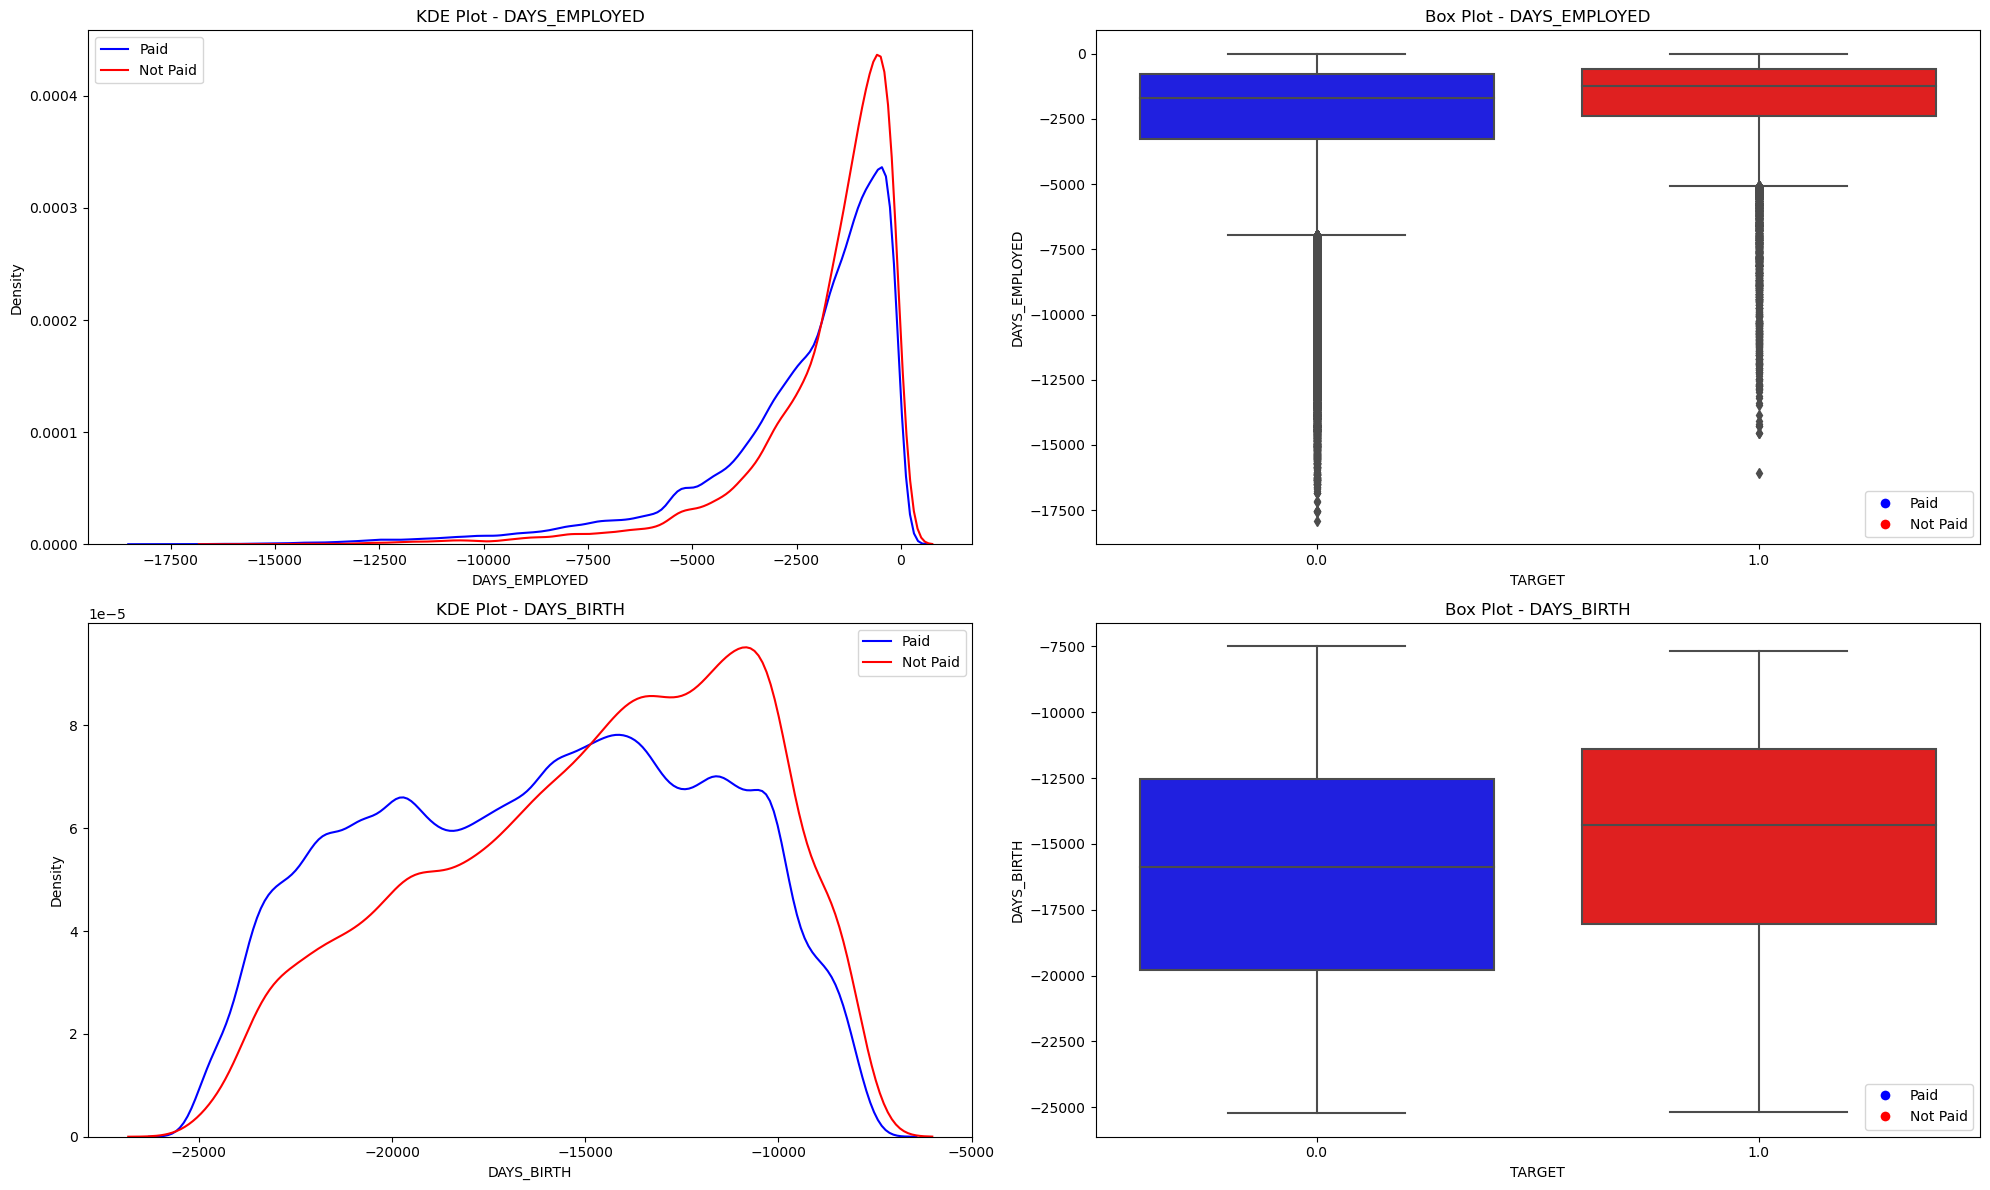

In [19]:
kdeplot_and_boxplot_by_target(dataset_removed, "TARGET", cols_test, figsize=(20, 6))

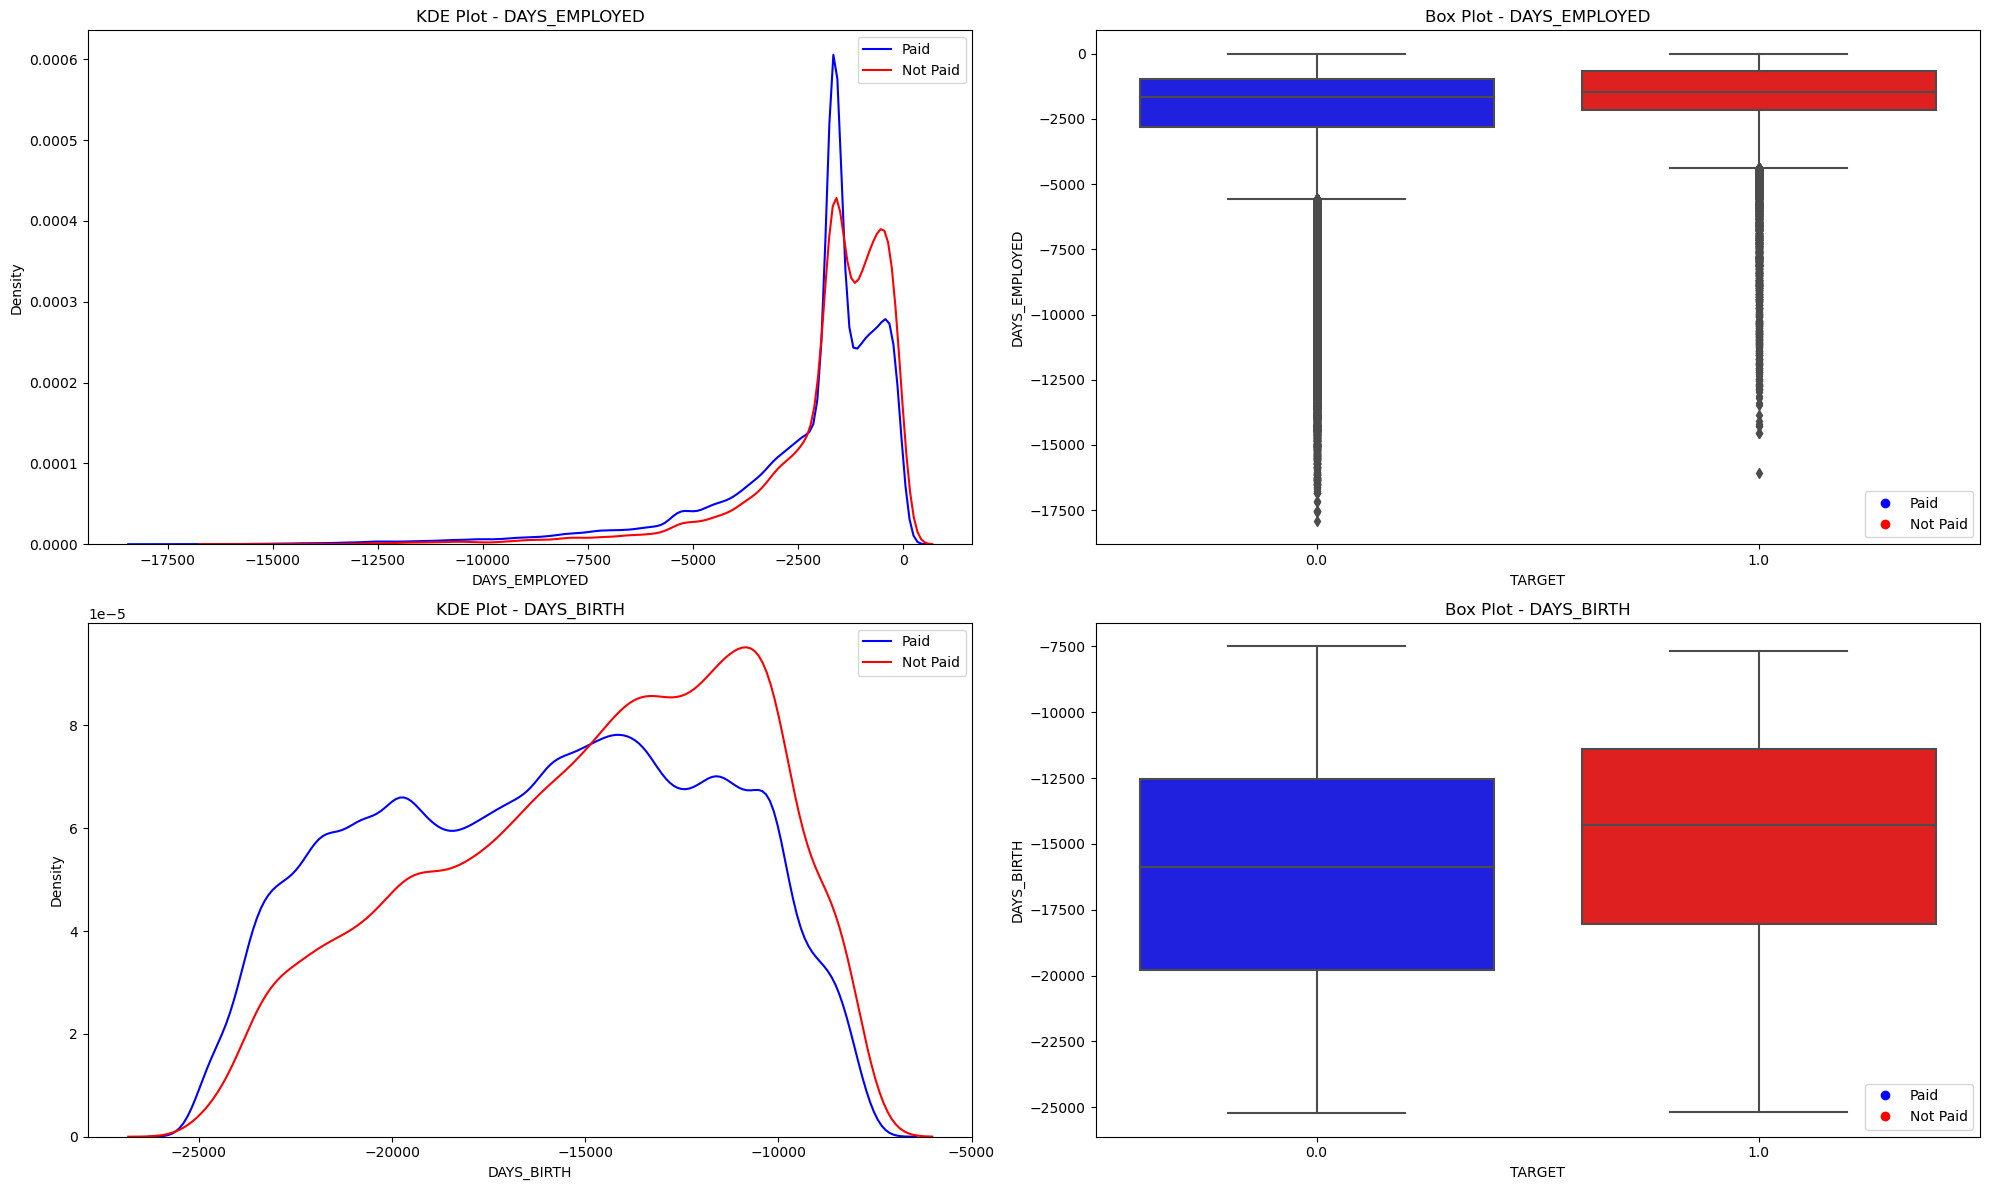

In [20]:
kdeplot_and_boxplot_by_target(data_fillna_median, "TARGET", cols_test, figsize=(20, 6))

# Splitter notre dataset

### On va définir X et y

In [21]:
X = data_fillna_median.drop('TARGET', axis=1).set_index('SK_ID_CURR')
y = data_fillna_median['TARGET']

### Diviser les données en ensembles d'entraînement et de test

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train = pd.DataFrame(X_train, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X.columns, index=X_test.index)
print(X_train.shape)
print(X_test.shape)

(246005, 542)
(61502, 542)


# Feature Selection

## Remove Low Variance Features

Sklearn provides the VarianceThreshold() function to remove less important features. It uses variance as the ranking criteria. We can use it to remove features that are constant (have a variance of 0, i.e. all rows have the same value) or nearly constant (have a variance that is very low).

In [23]:
# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0))
sel.fit(X_train)
cols_var = list(X.columns[~sel.get_support()])
print("Removed features:", cols_var)

Removed features: ['FLAG_MOBIL', 'NAME_FAMILY_STATUS_Unknown', 'BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_HouseConstruction_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN']


In [24]:
len(cols_var)

21

In [25]:
# Transform (remove low variance features)
X_train_var = sel.transform(X_train)
X_test_var = sel.transform(X_test)
X_train_var = pd.DataFrame(X_train_var, columns=X_train.drop(cols_var, axis=1).columns, index=X_train.index)
X_test_var = pd.DataFrame(X_test_var, columns=X_train.drop(cols_var, axis=1).columns, index=X_test.index)
print(X_train_var.shape)
print(X_test_var.shape)

(246005, 521)
(61502, 521)


## Remove Highly Correlated Features

Sklearn provides functions that allow us to compute and visualize correlations between our features. We looked at some of these in the chapter on multicollinearity. Sklearn doesn't provide a specific function to remove highly correlated features, so we need to write some code to do this. Here is a function that finds features that are highly correlated to other features in a dataset:

In [26]:
# Function to list features that are correlated
# Adds the first of the correlated pair only (not both)
def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

In [27]:
# Get a set of correlated features, based on threshold correlation of 0.80
cf = correlatedFeatures(X_train_var, 0.80)
cf

{'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_AMT_CREDIT_SUM_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_CNT_CREDIT_PROLONG_SUM',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'AMT_GOODS_PRICE',
 'APPROVED_AMT_ANNUITY_MAX',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'APPROVED_AMT_APPLICATION_MAX',
 'APPROVED_AMT_APPLICATION_MEAN',
 'APPROVED_AMT_APPLICATION_MIN',
 'APPROVED_AMT_CREDIT_MAX',
 'APPROVED_AMT_CREDIT_MEAN',
 'APPROVED_AMT_CREDIT_MIN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MIN',
 'APPROVED_AMT_GOODS_PRICE_MAX',
 'APPROVED_AMT_GOODS_PRICE_MEAN',
 'APPROVED_AMT_GOODS_PRICE_MIN',
 'APPROVED_APP_CREDIT_PERC_MAX',
 'APPROVED_APP_CREDIT_PERC_MEAN',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'APPROVED_DAYS_DECISION_MAX',
 'APPROVED_

In [28]:
len(cf)

112

In [29]:
# Remove the correlated features
X_train_corr = X_train_var.drop(cf, axis=1)
X_test_corr = X_test_var.drop(cf, axis=1)
print(X_train_corr.shape)
print(X_test_corr.shape)

(246005, 409)
(61502, 409)


In [30]:
cols_train = X_train_corr.columns
cols_test = X_test_corr.columns

## Select Features by Strength of Relationship to Target

Sklearn provides the SelectKBest() function to select a given number of features using a univariate statistical test. The statistical test function looks for the features that have the strongest relationship with the target feature.

In [31]:
# Perform feature selection using a univariate statistical test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # use this for classification tasks

kbest = SelectKBest(score_func=f_classif, k=10)
kbest.fit(X_train_corr, y_train)

print("Feature scores", kbest.scores_[:10])
most_corr_target = list(X_train_corr.columns[kbest.get_support()])
print("Selected features:", most_corr_target)

Feature scores [7.71100881e+02 1.05197929e+02 6.98745338e+00 9.16768425e+01
 1.09687587e+00 2.18397752e+02 3.64437643e+01 3.42676177e+02
 1.52977113e+03 9.85909478e+02]
Selected features: ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'PREV_NAME_PRODUCT_TYPE_walkin_MEAN']


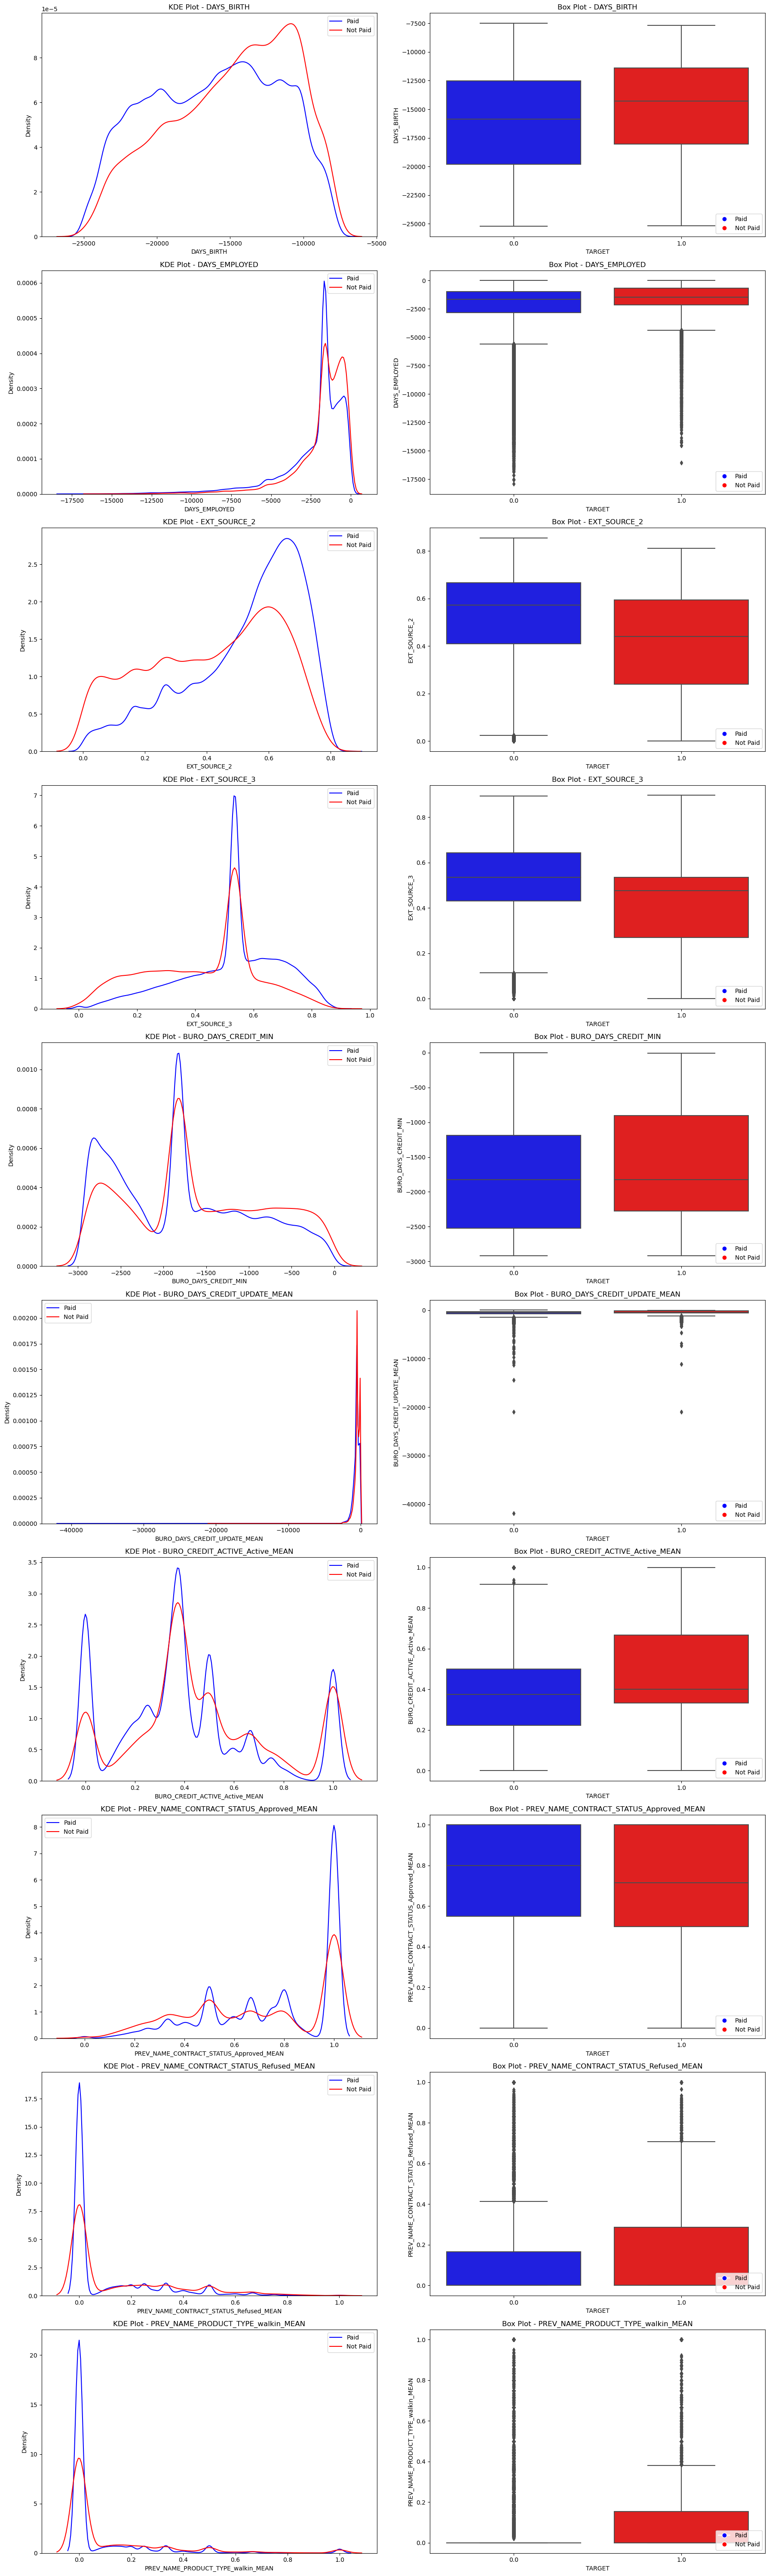

In [32]:
kdeplot_and_boxplot_by_target(data_fillna_median, "TARGET", most_corr_target, figsize=(18, 6))

In [33]:
# Transform (remove features not selected)
# X_train = kbest.transform(X_train)
# X_test = kbest.transform(X_test)
# print(X_train.shape)
# print(X_test.shape)

### On va mettre à l'échelle(scaler) les colonnes

In [34]:
scaler =  StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_corr)
X_test_scaled = scaler.transform(X_test_corr)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols_train, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols_test, index=X_test.index)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(246005, 409)
(61502, 409)


In [35]:
X_train_scaled.head(3)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
114418.0      -1.387109     -0.717489         1.503282     -0.577535   
443851.0       0.720924     -0.717489         1.503282     -0.577535   
231382.0      -1.387109     -0.717489        -0.665211      2.196802   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
114418.0            0.561335    2.351886     1.257643   
443851.0           -0.303059   -1.041779    -1.252908   
231382.0            0.215577    1.012576     1.686744   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
114418.0                      1.834300    0.364490       0.556345   
443851.0                     -0.204887    0.919343       0.803635   
231382.0                     -0.980604   -0.169516       0.897418   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
114418.0             0.073380        -0.927246         0.46838   
443851.0             0.377491         0.642931         0.46838   
231382.0             0.736404         1.768180         0.46838   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
114418.0          -0.498768          0.043658   -0.625028   -0.245444   
443851.0           2.004942          0.043658   -0.625028   -0.245444   
231382.0          -0.498768          0.043658   -0.625028   -0.245444   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
114418.0               -2.068127                -0.630415   
443851.0                1.859443                -1.548166   
231382.0                1.859443                 0.287336   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
114418.0                     -0.123809                   -0.231497   
443851.0                     -0.123809                   -0.231497   
231382.0                     -0.123809                   -0.231497   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
114418.0                 -0.291159               -0.547714      1.457651   
443851.0                 -0.291159               -0.547714      0.219631   
231382.0                 -0.291159               -0.547714      0.047567   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
114418.0       -0.105570                 -0.587593                 -0.319781   
443851.0        0.110796                 -0.587593                 -0.319781   
231382.0        0.264079                 -0.587593                 -0.319781   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
114418.0                 -0.841919         -0.00727         0.639685   
443851.0                  0.487439         -0.00727        -1.563268   
231382.0                 -0.267356         -0.00727        -1.563268   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
114418.0          -0.008789         -0.12472        -0.311688   
443851.0          -0.008789         -0.12472        -0.311688   
231382.0          -0.008789         -0.12472        -0.311688   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
114418.0          -0.013375        -0.298182        -0.062885   
4

# Equilibrage

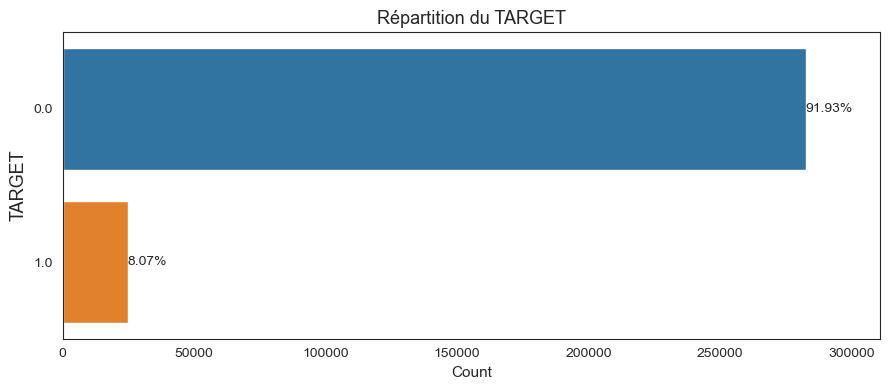

In [36]:
plt.style.use('default')
functions.countplot(data_fillna_median, "TARGET", figsize=(9, 4))

In [37]:
# Under sampling
undersample = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_unders, y_unders = undersample.fit_resample(X_train_scaled, y_train)
print("Before using RandomUnderSampler:", Counter(y_train))
print("Under sampled dataset shape", Counter(y_unders))

# Over sampling
oversample = SMOTE(random_state=42)
X_overs, y_overs = oversample.fit_resample(X_train_scaled, y_train)
print("Before using SMOTE:", Counter(y_train))
print("Over sampled dataset shape", Counter(y_overs))

Before using RandomUnderSampler: Counter({0.0: 226145, 1.0: 19860})
Under sampled dataset shape Counter({0.0: 19860, 1.0: 19860})
Before using SMOTE: Counter({0.0: 226145, 1.0: 19860})
Over sampled dataset shape Counter({0.0: 226145, 1.0: 226145})


# Modelisation

In [38]:
def fonction_metier(y_test, y_pred):
   
    
    TP_coeff = 0      # Vrais positifs
    FP_coeff = -1       # Faux positifs 
    FN_coeff = -10     # Faux négatifs 
    TN_coeff = 1       # Vrais négatifs
    
    (TN, FP, FN, TP) = metrics.confusion_matrix(y_test, y_pred).ravel()
    
    gain = (TP*TP_coeff + TN*TN_coeff + FP*FP_coeff + FN*FN_coeff)/(TN + FP + FN + TP)
    
    return gain

In [39]:
def conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize):
    '''Function for plotting Confusion Matrix and ROC Curve.'''
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Confusion Matrix
    ax1 = axes[0]
    ax1.set_title('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax1, annot_kws={"size": 18})
    ax1.set_ylabel('True Label', fontsize=18)  # Increase font size for ylabel
    ax1.set_xlabel('Predicted Label', fontsize=18)  # Increase font size for xlabel
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # ROC Curve
    ax2 = axes[1]
    ax2.set_title('ROC Curve')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='steelblue', linewidth=5, label=f'AUC = {auc:.2f}', markersize=18)
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    ax2.set_xlabel('False Positive Rate', fontsize=18)  # Increase font size for xlabel
    ax2.set_ylabel('True Positive Rate', fontsize=18)  # Increase font size for ylabel
    ax2.legend(fontsize=18)  # Increase font size for legend
    plt.tight_layout()
    plt.show()

    return cf_matrix

In [40]:
from sklearn.metrics import make_scorer

cost_scorer = make_scorer(fonction_metier, greater_is_better=True)

In [41]:
def evaluation_score(model, X_train, y_train, X_test, y_test, model_name, figsize):
    '''
    Calculate, display, and save different metrics.
    
    :param model: The machine learning model to evaluate.
    :param X_train: Training data.
    :param y_train: Target labels for training data.
    :param X_test: Testing data.
    :param y_test: True labels for testing data.
    :param figsize: Tuple specifying the figure size for ROC curve.
    :param model_name: Name of the model (for result DataFrame).
    :return: A DataFrame with metrics.
    '''
    start_time = time.time()
    model.fit(X_train, y_train)
    execution_time = time.time() - start_time
    execution_time = round(execution_time,3)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metier = fonction_metier(y_test, y_pred).round(2)
    accuracy = metrics.accuracy_score(y_test, y_pred).round(2)
    precision = metrics.precision_score(y_test, y_pred).round(2)
    recall = metrics.recall_score(y_test, y_pred).round(2)
    f1_score = metrics.f1_score(y_test, y_pred).round(2)
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba).round(2)
    
    # Display classification report
    print(classification_report(y_test, y_pred))
    
    # Display confusion matrix and ROC curve
    conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize)
    
    # Create a DataFrame with rounded metrics
    results = pd.DataFrame({'model': [model_name],
                            'accuracy': [accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1_score': [f1_score],
                            'roc_auc_score': [auc_score],
                            'custom_score': [metier],
                            'execution_time': [execution_time]})
    display(results)
    
    return results, precision, recall, f1_score, auc_score, metier

In [42]:
def mlfow_track(exp_name, model, X_train, y_train, X_test, y_test, model_name, figsize):
    model = model
    plt.style.use('fivethirtyeight')
    mlflow.set_experiment(exp_name)
    mlflow.sklearn.autolog()
    #mlflow.lightgbm.autolog()
    with mlflow.start_run(run_name=exp_name):
        model.fit(X_train, y_train)
        results, precision, recall, f1_score, auc_score,\
        metier = evaluation_score(model, X_train, y_train, X_test, y_test, model_name, figsize) 
        mlflow.log_metric("custom_score", metier)
        mlflow.log_metric("val_precision", precision)
        mlflow.log_metric("val_recall", recall)
        mlflow.log_metric("val_f1_score", f1_score)
        mlflow.log_metric("val_rocauc", auc_score)
    return model, results

# Logistic Regression

## Avec data origine

2023/09/12 16:35:34 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5
2023/09/12 16:35:52 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.51      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



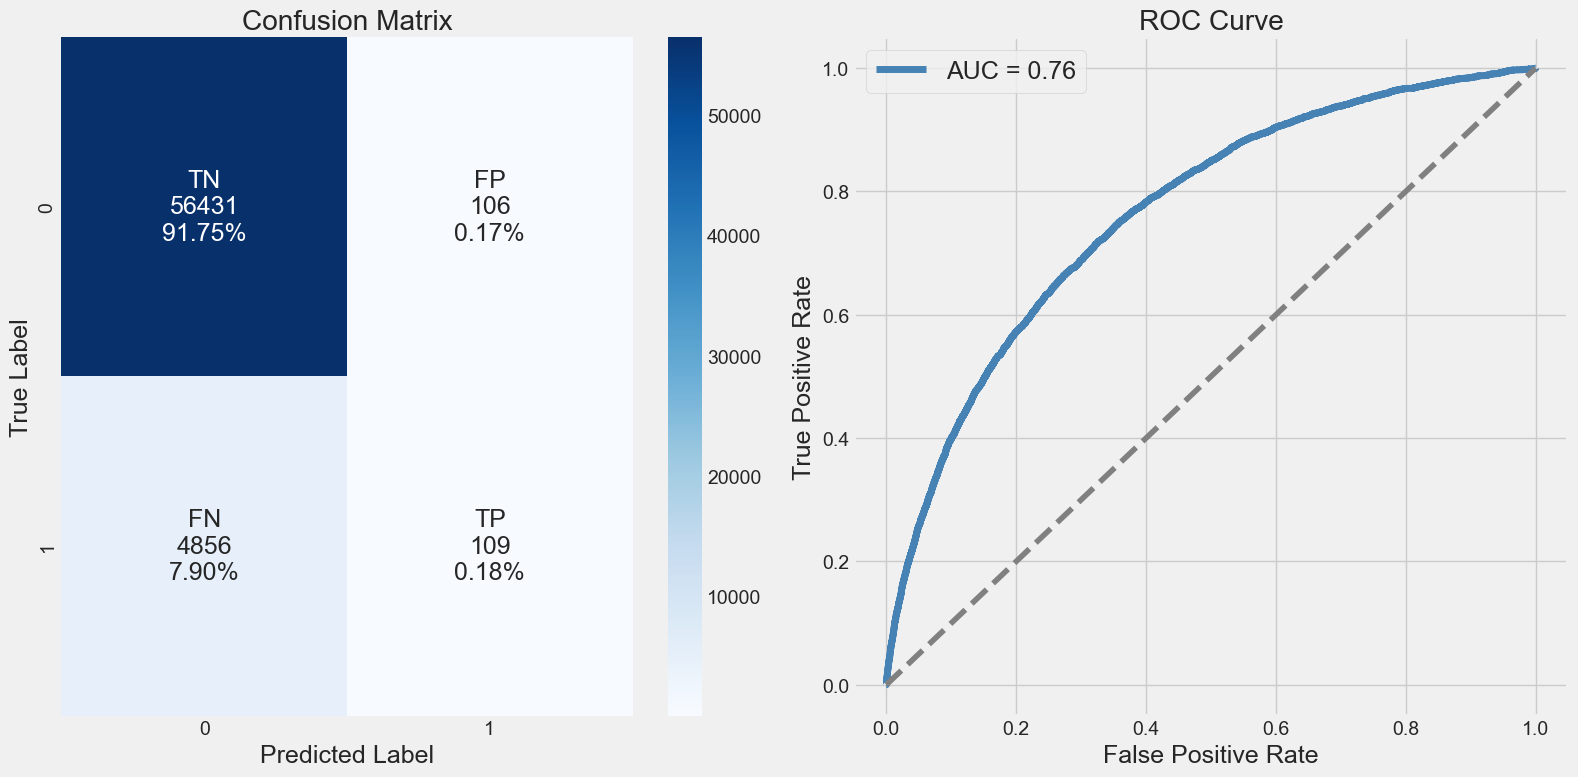

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_origine      0.92       0.51    0.02      0.04           0.76   

   custom_score  execution_time  
0          0.13          17.113

In [43]:
model = LogisticRegression()
lr_origine, results_lr_origine = mlfow_track("lr_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lr_origine", (16,8))

# Undersampled

2023/09/12 16:36:00 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5
2023/09/12 16:36:05 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5


              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.70      0.76     61502



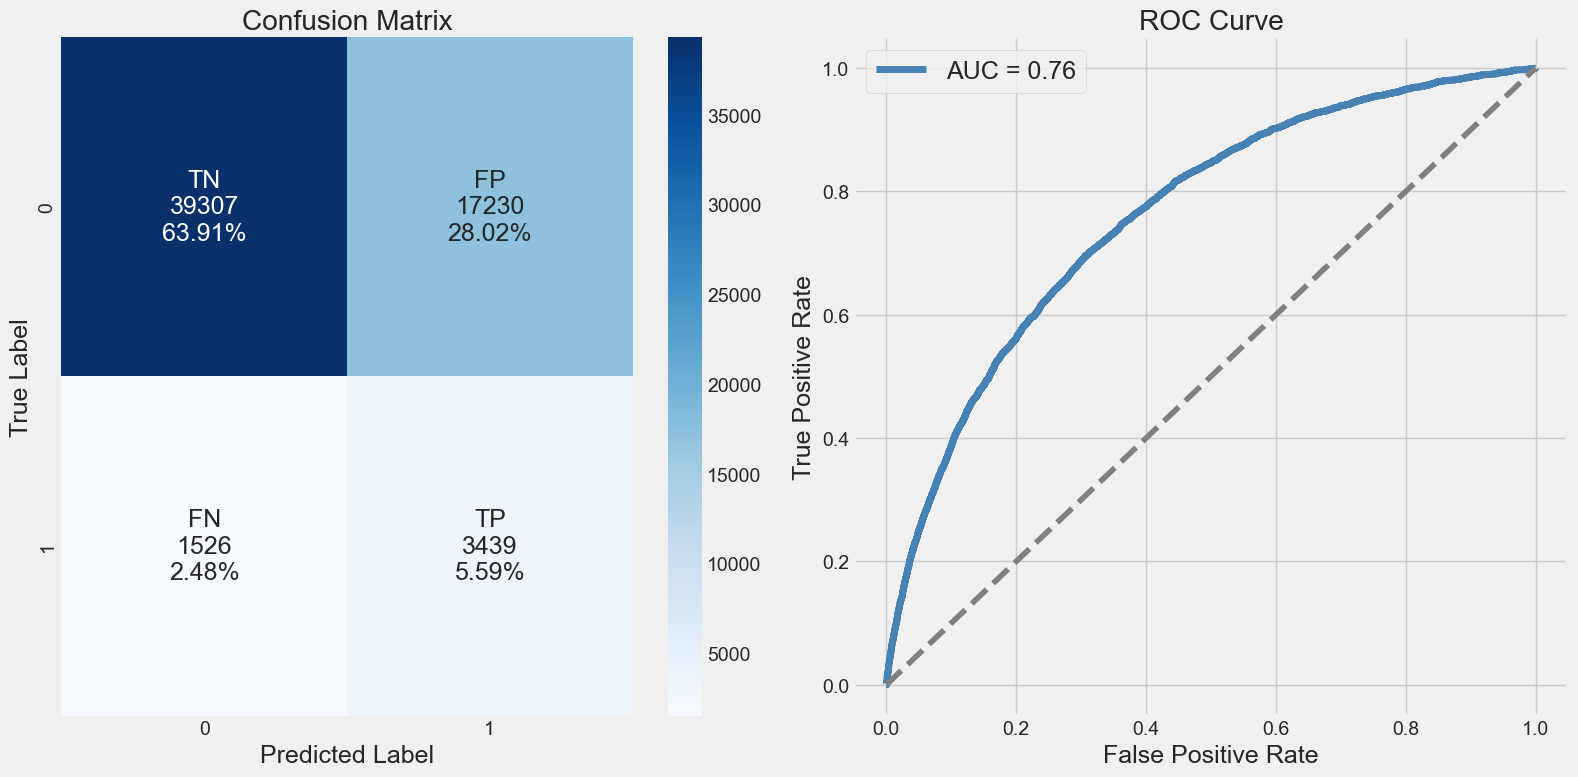

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_unders       0.7       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.11           4.062

In [44]:
model = LogisticRegression()
lr_unders, results_lr_unders = mlfow_track("lr_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "lr_unders", (16,8))

In [45]:
lr_unders

LogisticRegression()

In [46]:
results_lr_unders

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_unders       0.7       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.11           4.062

# Oversampled

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     56537
         1.0       0.17      0.65      0.26      4965

    accuracy                           0.71     61502
   macro avg       0.56      0.68      0.54     61502
weighted avg       0.89      0.71      0.77     61502



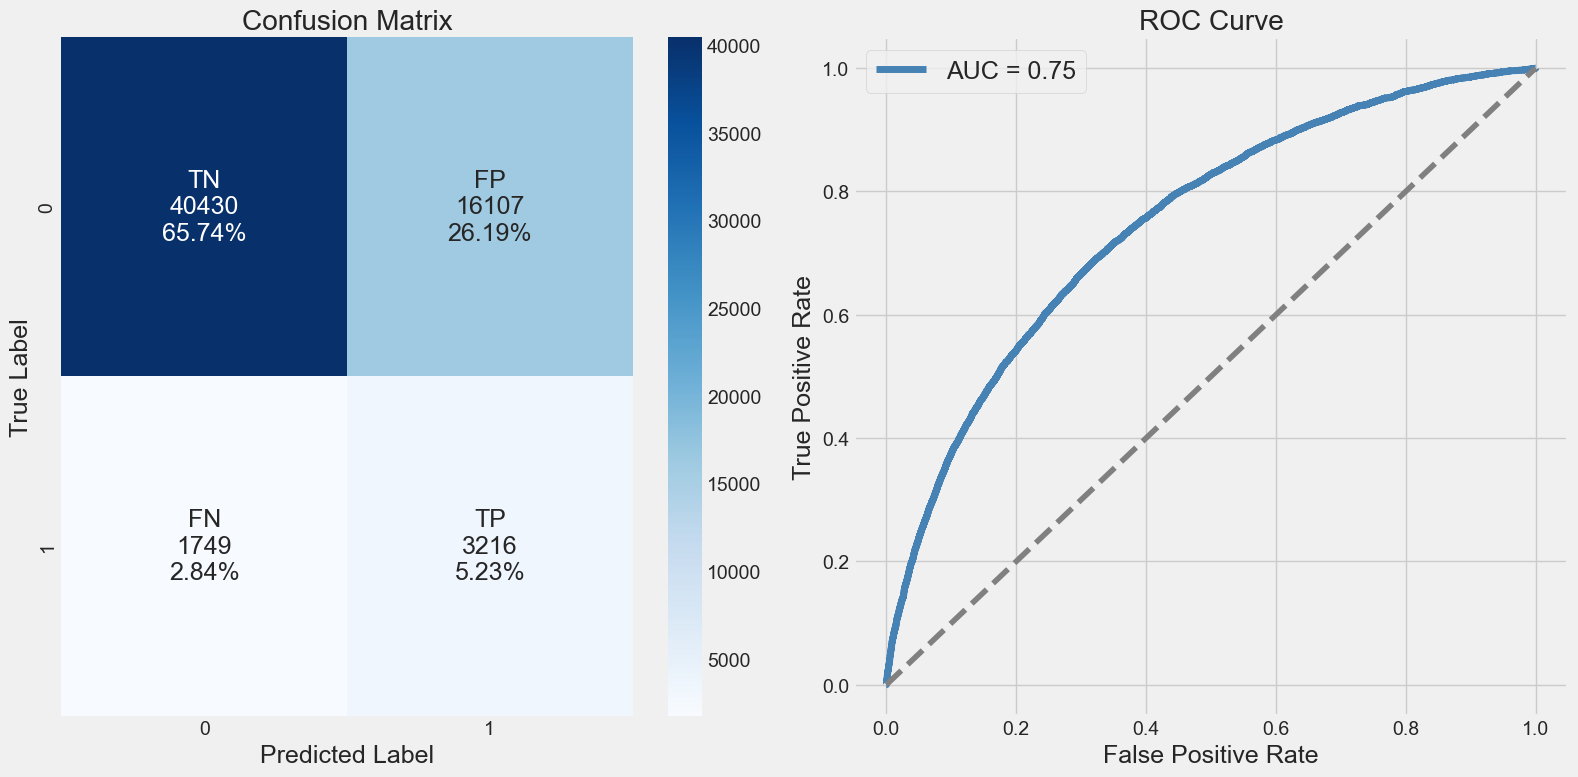

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_overs      0.71       0.17    0.65      0.26           0.75   

   custom_score  execution_time  
0          0.11           31.38

In [47]:
model = LogisticRegression()
lr_overs, results_lr_overs = mlfow_track("lr_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "lr_overs", (16,8))

# Class weigth balanced

2023/09/12 16:37:35 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5
2023/09/12 16:37:52 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5


              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



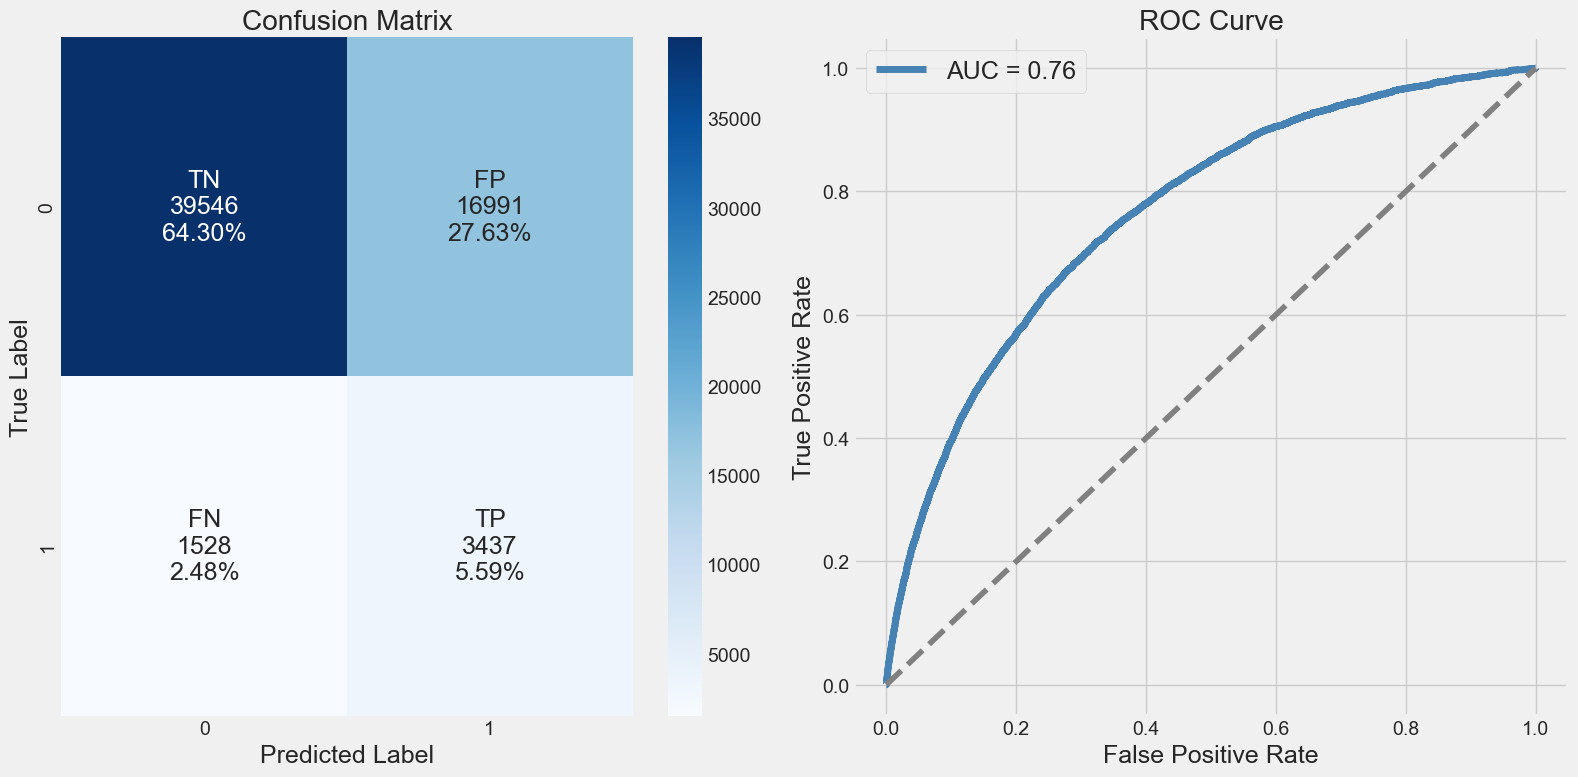

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_balanced       0.7       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.12          16.979

In [48]:
model = LogisticRegression(class_weight="balanced")
lr_balanced, results_lr_balanced = mlfow_track("lr_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lr_balanced", (16,8))

## Comparaison des résultas Logistic Regression

In [49]:
comp_lr = pd.concat([results_lr_origine, results_lr_unders, results_lr_overs, results_lr_balanced], axis=0)
comp_lr

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lr_origine      0.92       0.51    0.02      0.04           0.76   
0    lr_unders      0.70       0.17    0.69      0.27           0.76   
0     lr_overs      0.71       0.17    0.65      0.26           0.75   
0  lr_balanced      0.70       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.13          17.113  
0          0.11           4.062  
0          0.11          31.380  
0          0.12          16.979

# Random Forest

# Data origine

2023/09/12 16:40:44 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5
2023/09/12 16:43:31 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.78      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.85      0.50      0.48     61502
weighted avg       0.91      0.92      0.88     61502



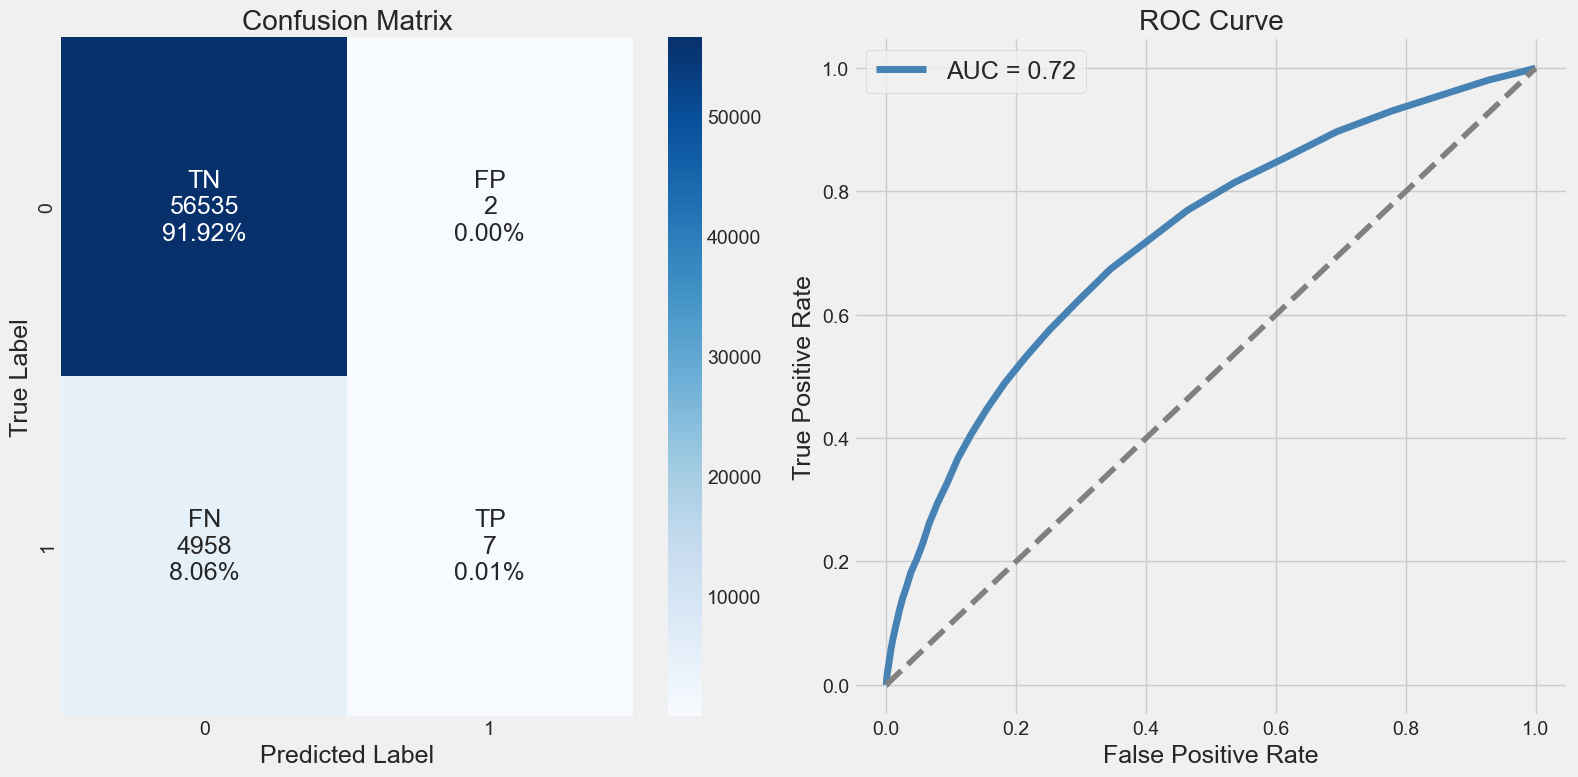

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_origine      0.92       0.78     0.0       0.0           0.72   

   custom_score  execution_time  
0          0.11         167.757

In [50]:
model = RandomForestClassifier(random_state=42)
rf_origine, results_rf_origine = mlfow_track("rf_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "rf_origine", (16,8))

# Undersampled

2023/09/12 16:43:58 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5
2023/09/12 16:44:18 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5


              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81     56537
         1.0       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.53     61502
weighted avg       0.90      0.69      0.76     61502



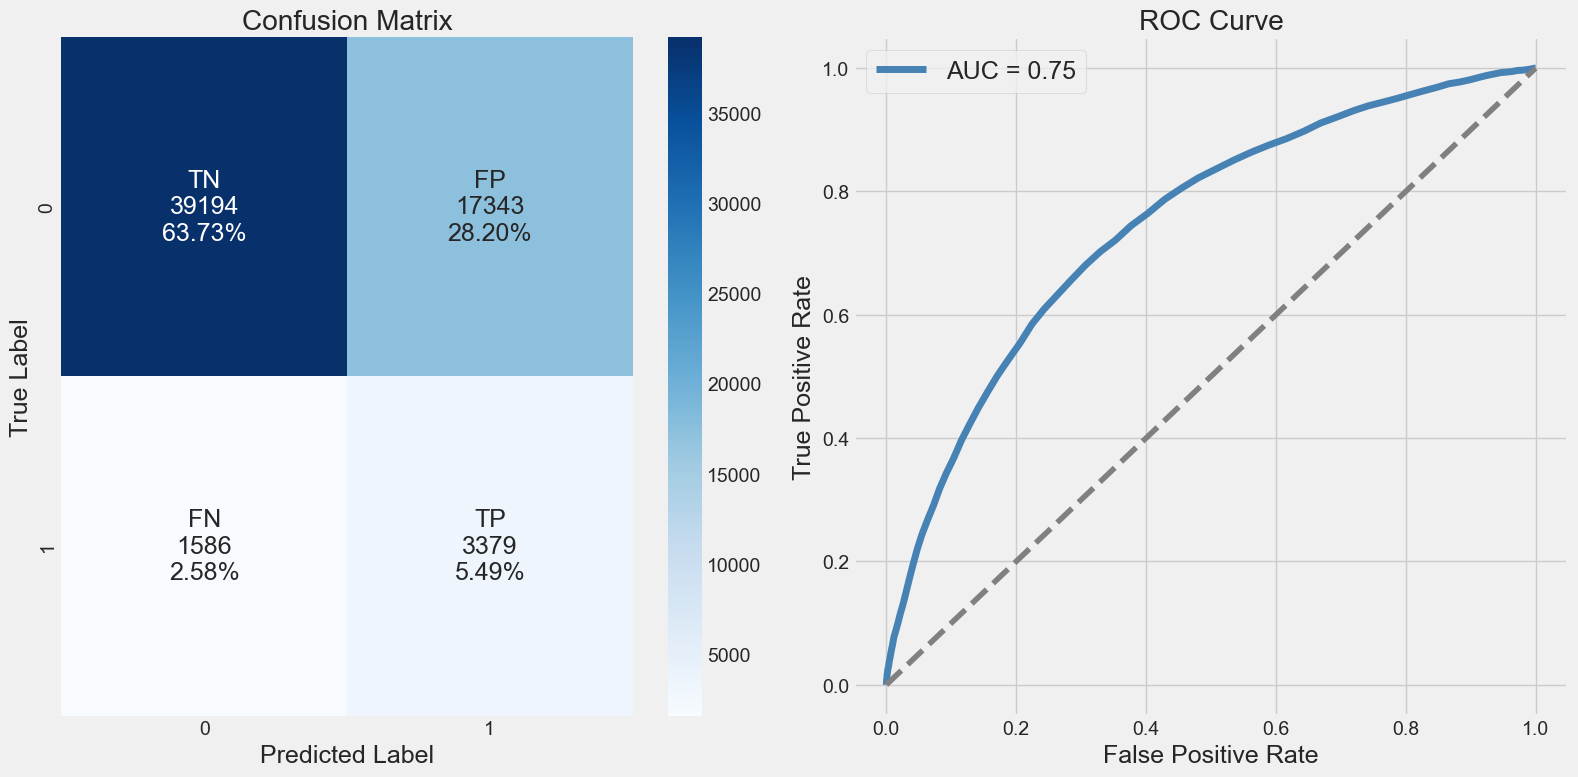

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_unders      0.69       0.16    0.68      0.26           0.75   

   custom_score  execution_time  
0           0.1          20.015

In [51]:
model = RandomForestClassifier(random_state=42)
rf_unders, results_rf_unders = mlfow_track("rf_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "rf_unders", (16,8))

## Oversampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.33      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.63      0.51      0.50     61502
weighted avg       0.87      0.92      0.88     61502



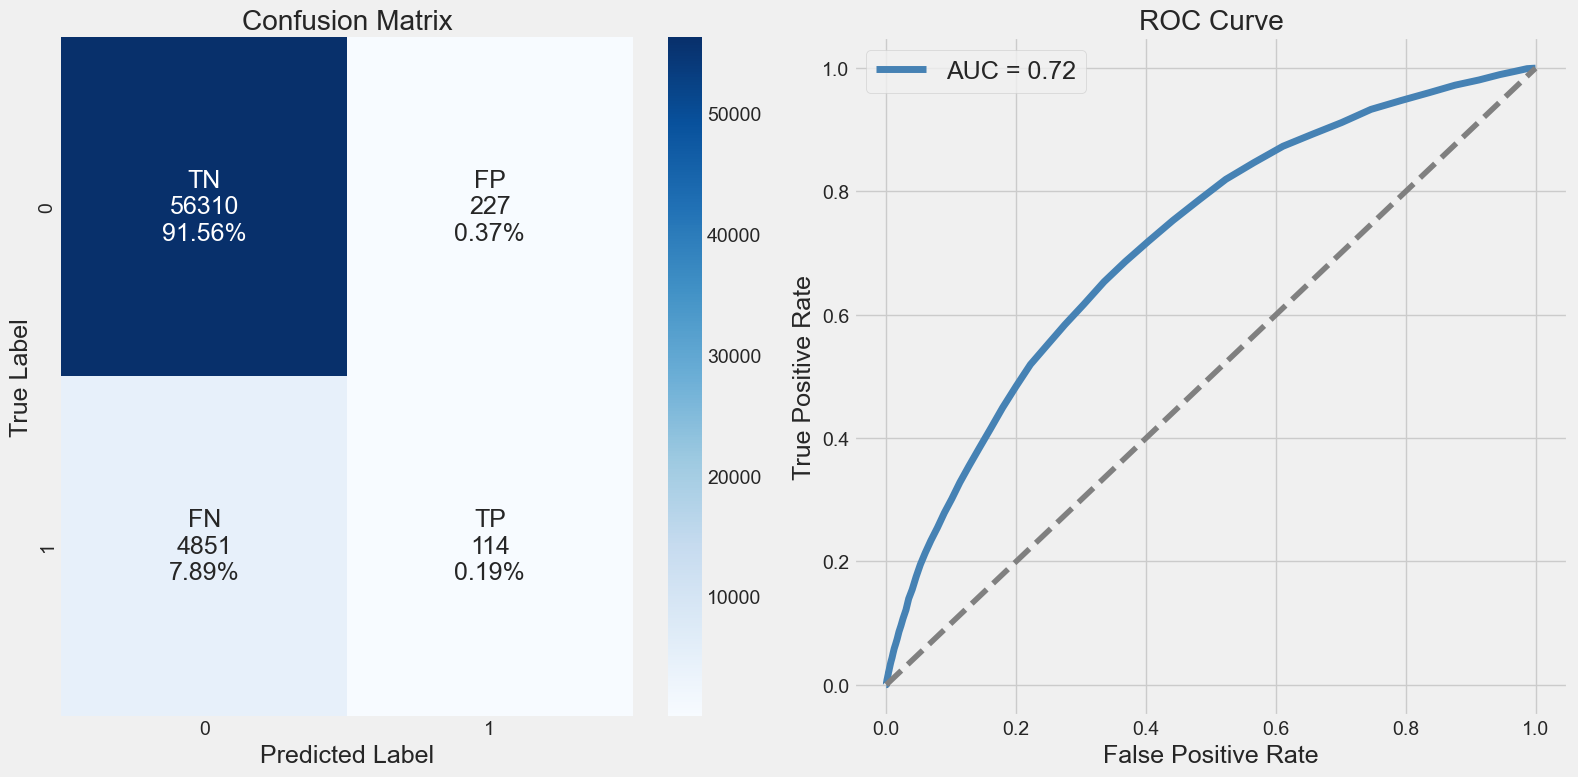

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_overs      0.92       0.33    0.02      0.04           0.72   

   custom_score  execution_time  
0          0.12         317.899

In [52]:
model = RandomForestClassifier(random_state=42)
rf_overs, results_rf_overs = mlfow_track("rf_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "rf_overs", (16,8))

# Class weigth balanced

2023/09/12 16:57:17 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5
2023/09/12 17:12:23 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: 5


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.62      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.77      0.50      0.48     61502
weighted avg       0.90      0.92      0.88     61502



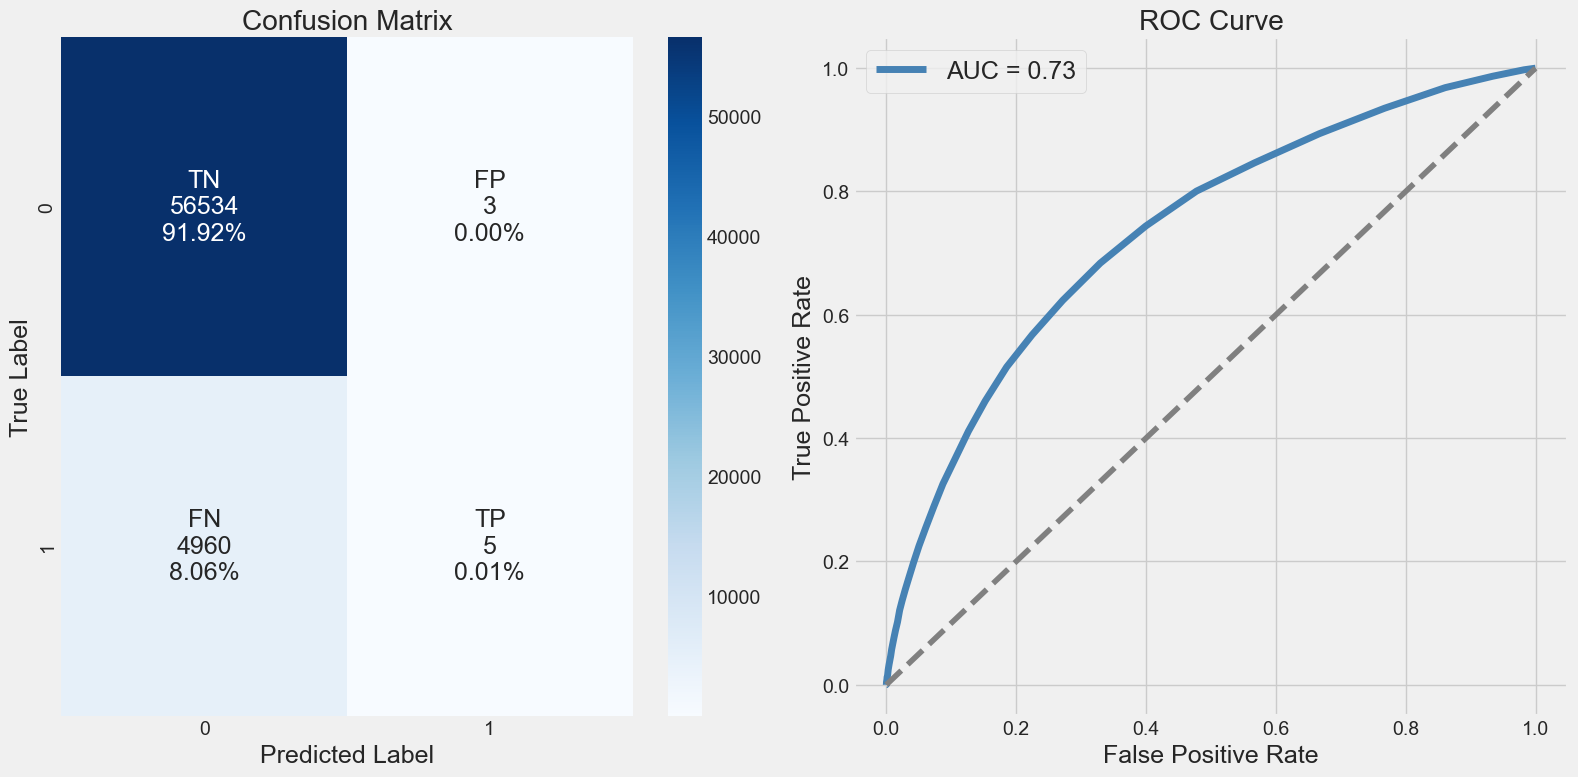

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_balanced      0.92       0.62     0.0       0.0           0.73   

   custom_score  execution_time  
0          0.11         906.049

In [53]:
model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_balanced, results_rf_balanced = mlfow_track("rf_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "rf_balanced", (16,8))

## Comparaison des résultas Random Forest

In [54]:
comp_rf = pd.concat([results_rf_origine, results_rf_unders, results_rf_overs, results_rf_balanced], axis=0)
comp_rf

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   rf_origine      0.92       0.78    0.00      0.00           0.72   
0    rf_unders      0.69       0.16    0.68      0.26           0.75   
0     rf_overs      0.92       0.33    0.02      0.04           0.72   
0  rf_balanced      0.92       0.62    0.00      0.00           0.73   

   custom_score  execution_time  
0          0.11         167.757  
0          0.10          20.015  
0          0.12         317.899  
0          0.11         906.049

# Lightgbm

# Data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.53      0.03      0.06      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.51      0.51     61502
weighted avg       0.89      0.92      0.89     61502



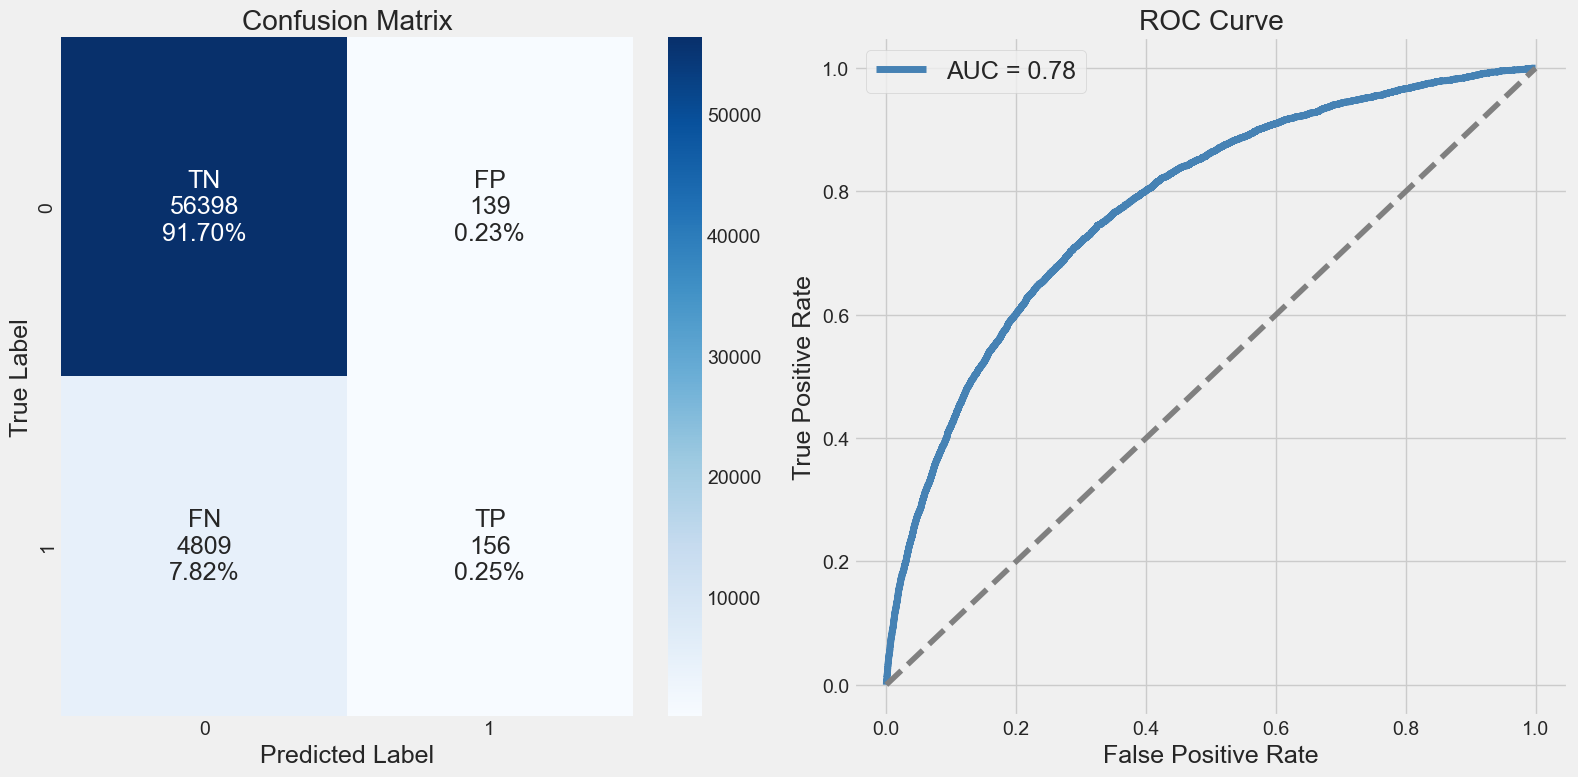

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_origine      0.92       0.53    0.03      0.06           0.78   

   custom_score  execution_time  
0          0.13           4.867

In [55]:
model = LGBMClassifier(random_state=42)
lgbm_origine, results_lgbm_origine = mlfow_track("lgbm_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.70      0.28      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



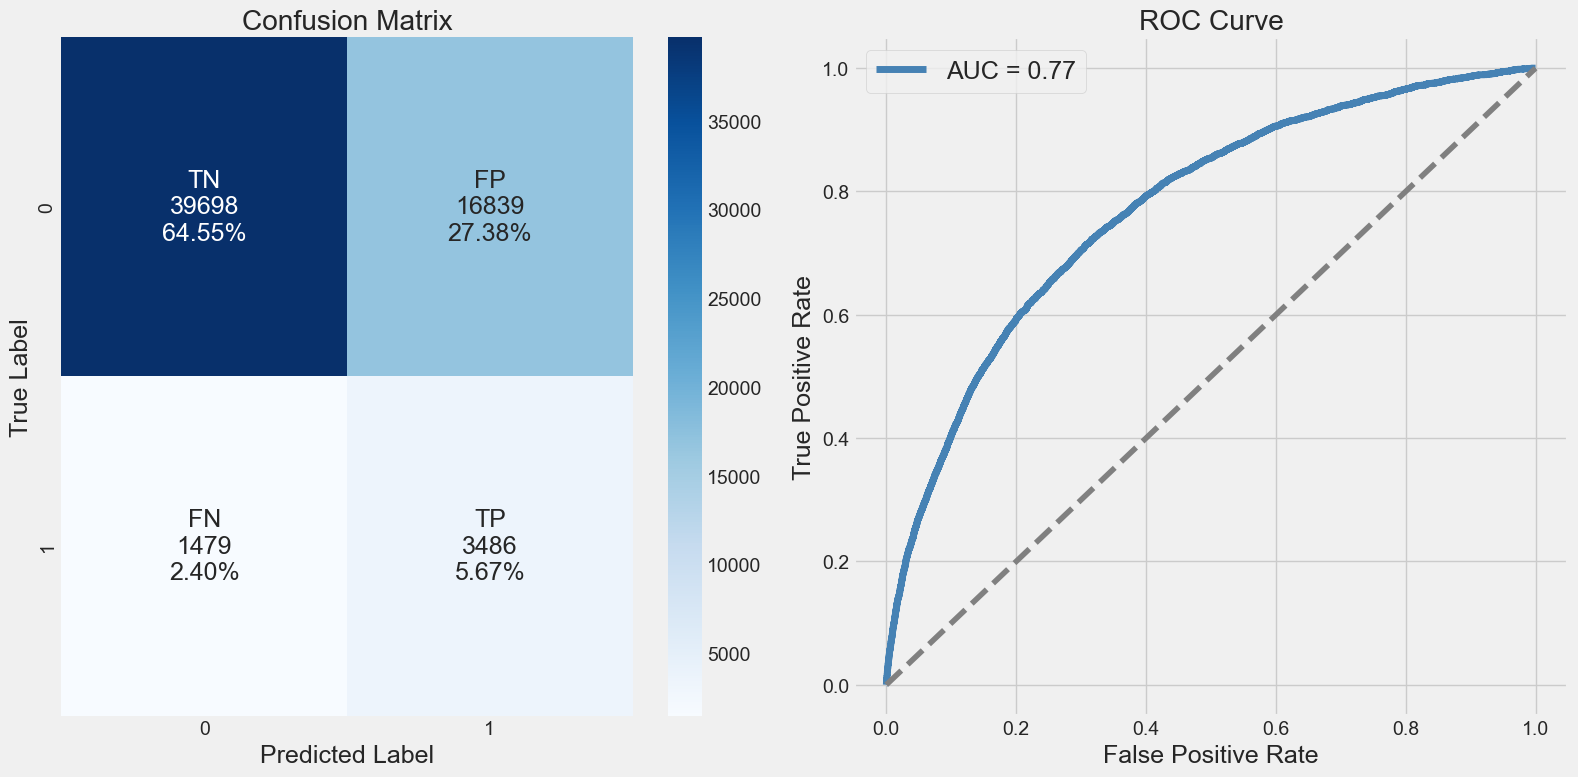

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_unders       0.7       0.17     0.7      0.28           0.77   

   custom_score  execution_time  
0          0.13           1.178

In [56]:
model = LGBMClassifier(random_state=42)
lgbm_unders, results_lgbm_unders = mlfow_track("lgbm_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "lgbm_unders", (16,8))

## Oversampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.53      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



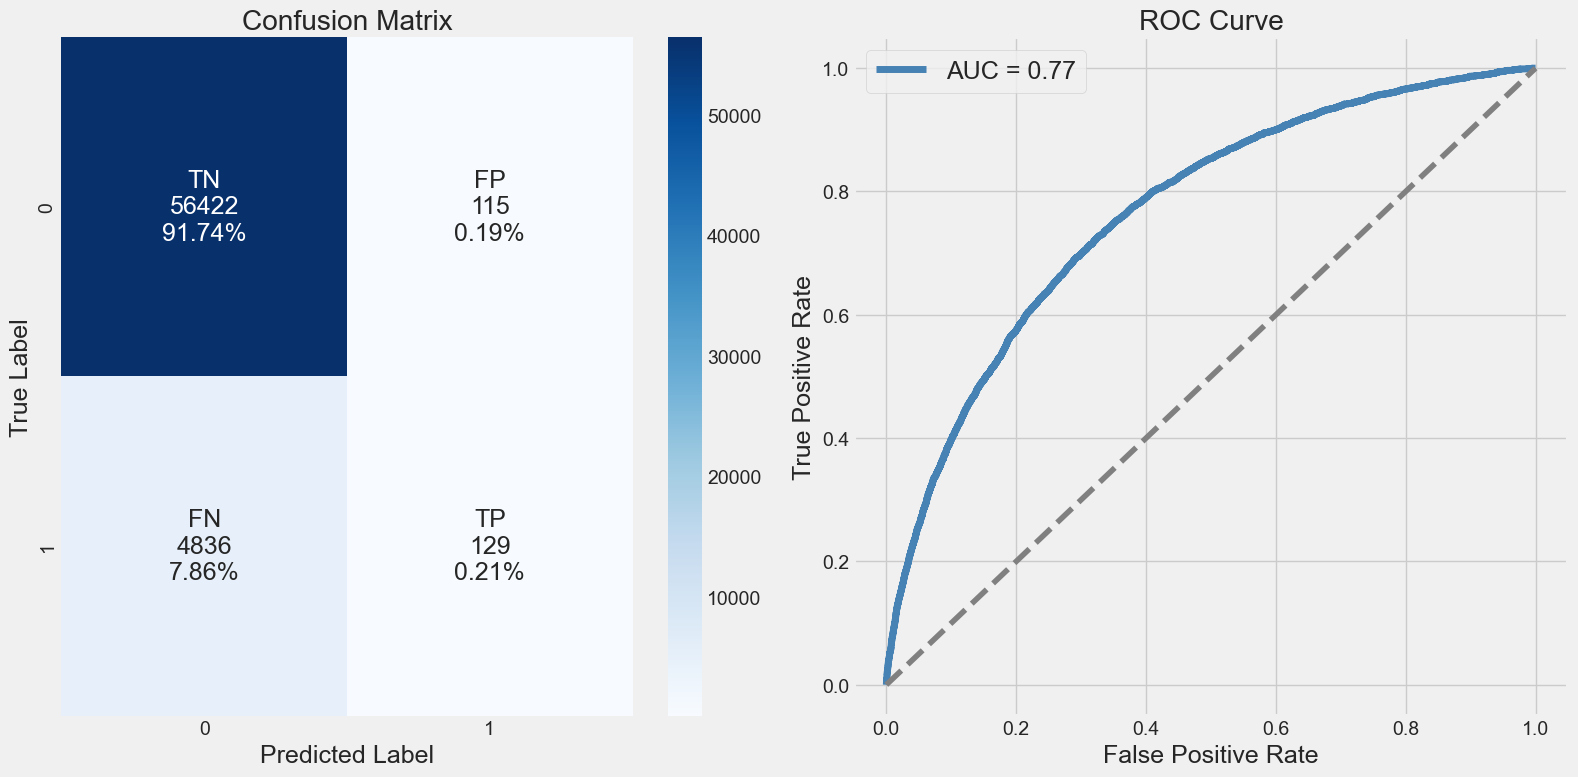

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_overs      0.92       0.53    0.03      0.05           0.77   

   custom_score  execution_time  
0          0.13           11.23

In [57]:
model = LGBMClassifier(random_state=42)
lgbm_overs, results_lgbm_overs = mlfow_track("lgbm_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "lgbm_overs", (16,8))

# Class weigth balanced

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56537
         1.0       0.18      0.69      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.78     61502



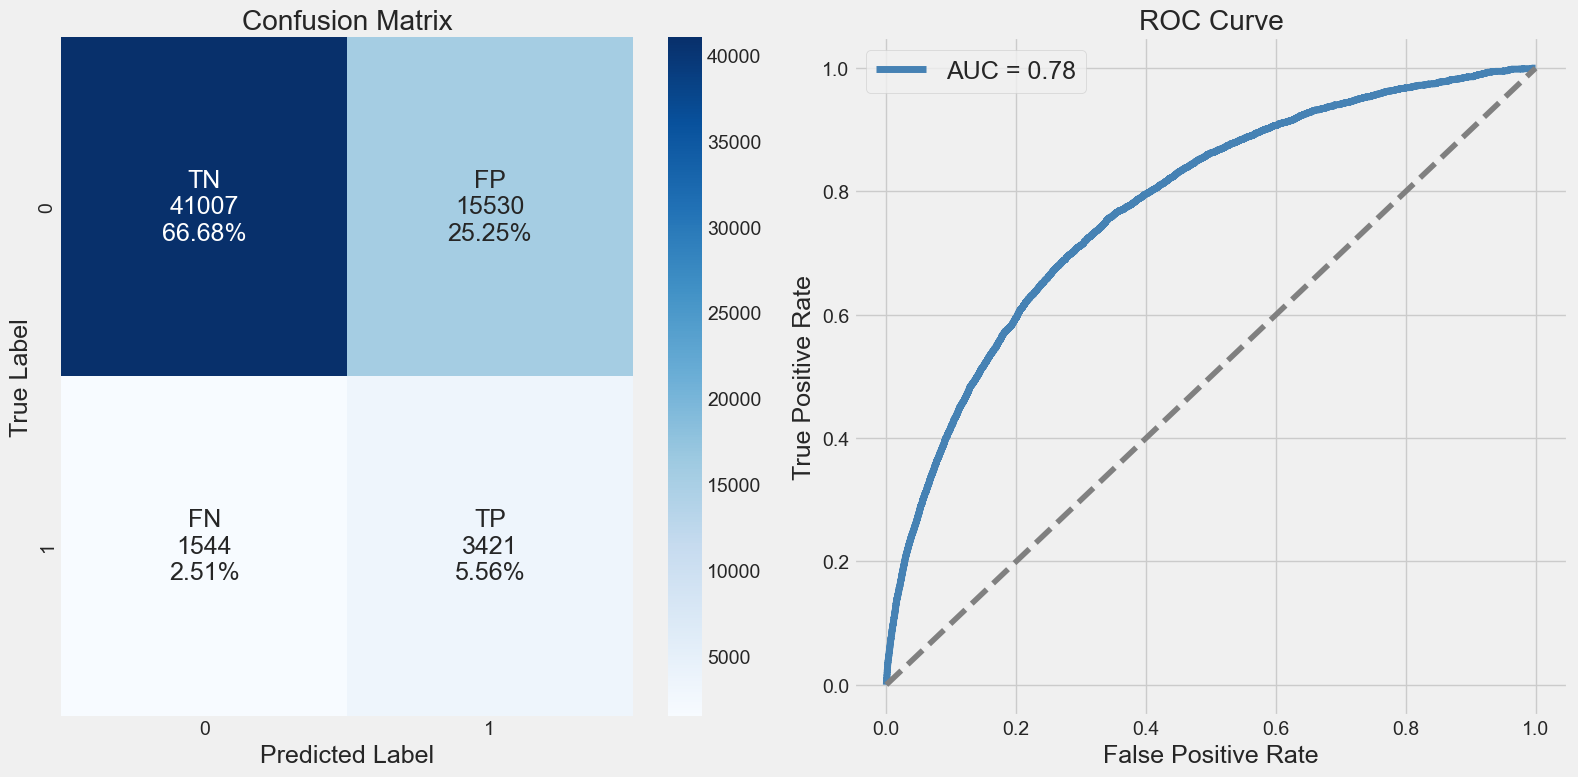

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.16           4.903

In [58]:
model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_balanced, results_lgbm_balanced = mlfow_track("lgbm_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_balanced", (16,8))

## Comparaison des résultas LGBM

In [59]:
comp_lgbm = pd.concat([results_lgbm_origine, results_lgbm_unders, results_lgbm_overs, results_lgbm_balanced], axis=0)
comp_lgbm

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lgbm_origine      0.92       0.53    0.03      0.06           0.78   
0    lgbm_unders      0.70       0.17    0.70      0.28           0.77   
0     lgbm_overs      0.92       0.53    0.03      0.05           0.77   
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.13           4.867  
0          0.13           1.178  
0          0.13          11.230  
0          0.16           4.903

# Comparaison Total

In [60]:
comp_total = pd.concat([comp_lr, comp_rf, comp_lgbm], axis=0)
comp_total.sort_values("roc_auc_score", ascending=False)

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lgbm_origine      0.92       0.53    0.03      0.06           0.78   
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   
0    lgbm_unders      0.70       0.17    0.70      0.28           0.77   
0     lgbm_overs      0.92       0.53    0.03      0.05           0.77   
0     lr_origine      0.92       0.51    0.02      0.04           0.76   
0      lr_unders      0.70       0.17    0.69      0.27           0.76   
0    lr_balanced      0.70       0.17    0.69      0.27           0.76   
0       lr_overs      0.71       0.17    0.65      0.26           0.75   
0      rf_unders      0.69       0.16    0.68      0.26           0.75   
0    rf_balanced      0.92       0.62    0.00      0.00           0.73   
0     rf_origine      0.92       0.78    0.00      0.00           0.72   
0       rf_overs      0.92       0.33    0.02      0.04           0.72   

   custom_score  execution_time  
0          0.13           4.867  
0          0.16           4.903  
0          0.13           1.178  
0          0.13          11.230  
0          0.13          17.113  
0          0.11           4.062  
0          0.12          16.979  
0          0.11          31.380  
0          0.10          20.015  
0          0.11         906.049  
0          0.11         167.757  
0          0.12         317.899

# Explainability

In [61]:
import shap
shap.initjs()

In [62]:
X_test_scaled.shape

(61502, 409)

In [63]:
X_test_sample = X_test_scaled.sample(10, random_state=42)
X_test_sample.shape

(10, 409)

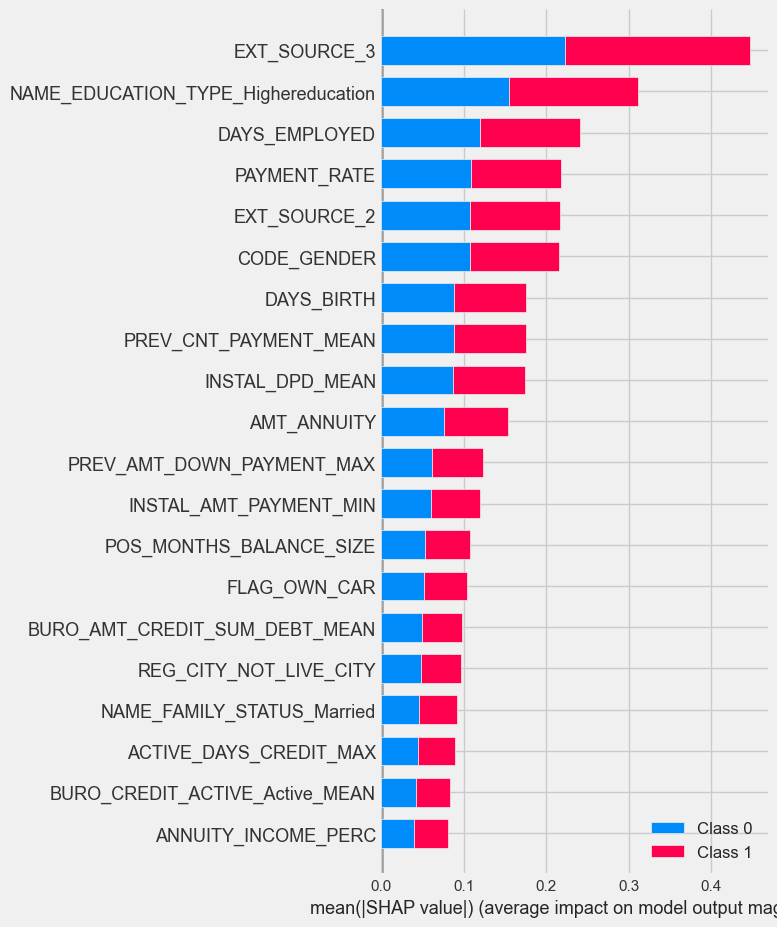

In [64]:
# Explain model predictions using shap library:
model = lgbm_balanced
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_sample)

100%|===================| 61483/61502 [03:09<00:00]        

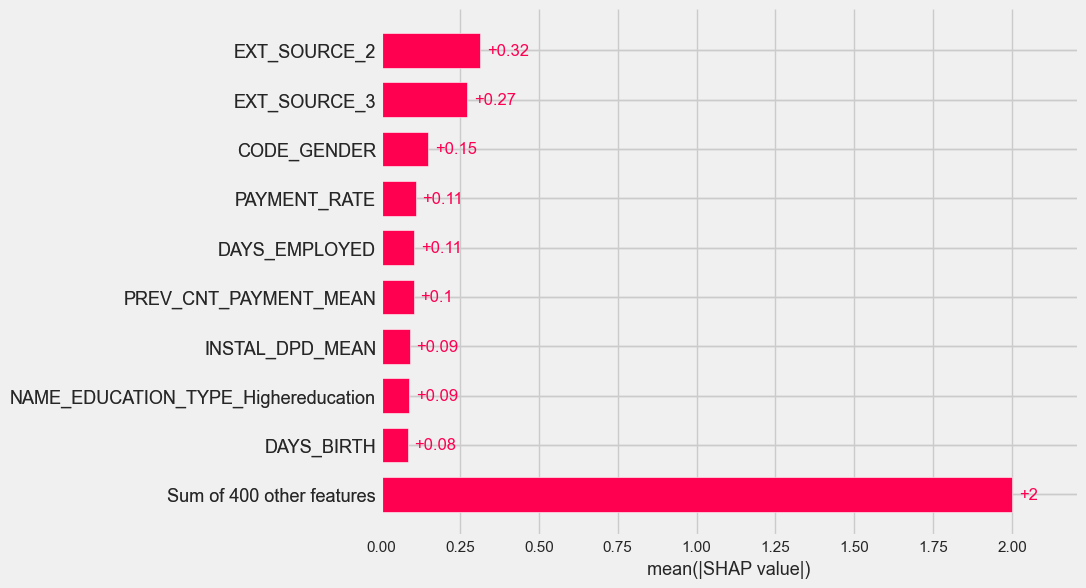

In [65]:
explainer = shap.Explainer(model, X_test_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)
shap.plots.bar(shap_values)

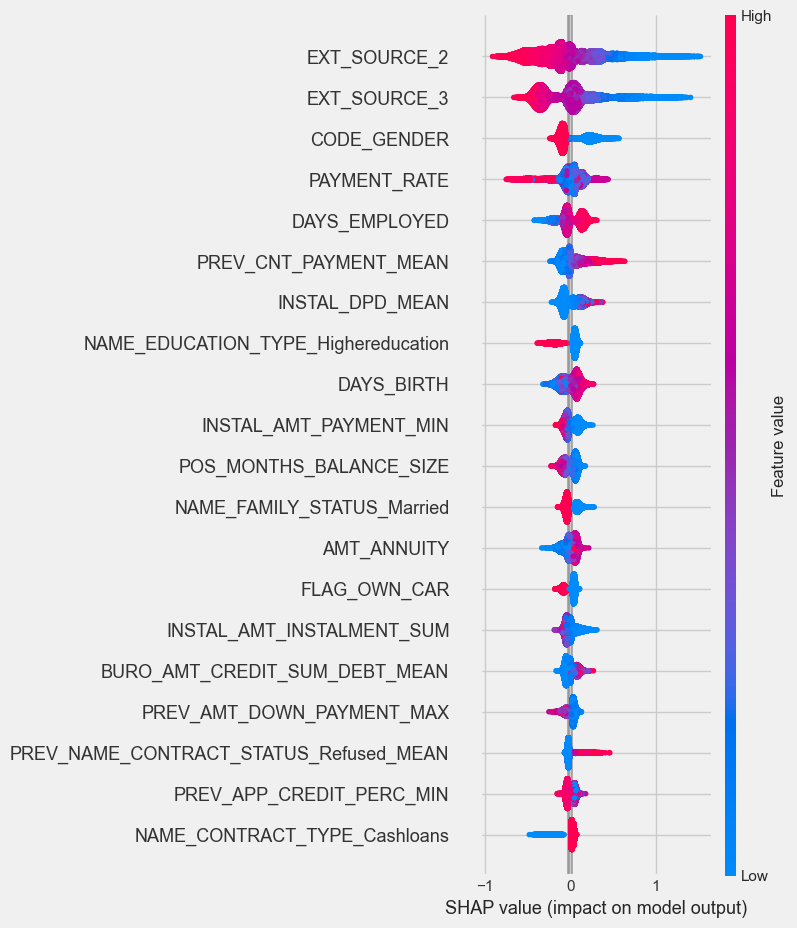

In [66]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns)

In [67]:
model = lgbm_balanced
X_test_sample = X_test_scaled.sample(10, random_state=42)

subsampled_test_data =X_test_sample

# explain first sample from test data
start_time = time.time()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

print("Tree Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", "lgbm_balanced")
print("SHAP expected value", explainer.expected_value)
print("Model mean value", model.predict_proba(X_train_scaled).mean(axis=0))
print("Model prediction for test data", model.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data.iloc[0], 
                feature_names=X_train_scaled.columns)

Tree Explainer SHAP run time 0.048  seconds.  lgbm_balanced
SHAP expected value [0.5337230246070896, -0.5337230246070896]
Model mean value [0.60762704 0.39237296]
Model prediction for test data [[0.332378   0.667622  ]
 [0.70992411 0.29007589]
 [0.6781015  0.3218985 ]
 [0.53322354 0.46677646]
 [0.62120725 0.37879275]
 [0.43836828 0.56163172]
 [0.42615436 0.57384564]
 [0.36654677 0.63345323]
 [0.76526124 0.23473876]
 [0.85052001 0.14947999]]


In [ ]:
# compute SHAP values
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_train_scaled, check_additivity=False)
shap.plots.bar(shap_values)

 96%|=================== | 237197/246005 [12:18<00:27]       

In [ ]:
X_train_scaled.head(2)